<span style='color:Blue ;
             font-size:30px;'>
    Computational Intelligence assignment №2.  </span><br>
<span style='color:Red ;
             font-size:15px;'>
    Student : Amir Zakirov.  </span><br>

Some notes:
1) Task 5 is available in Task5.pdf </br>
2) Due to the fact that the coordinates of the legs are set randomly, there are cases when they are located too atypically, and the force values are obtained unusual </br>
3) Planes are defined in the same way as in the previous assignment, so some classes and functions were taken from it

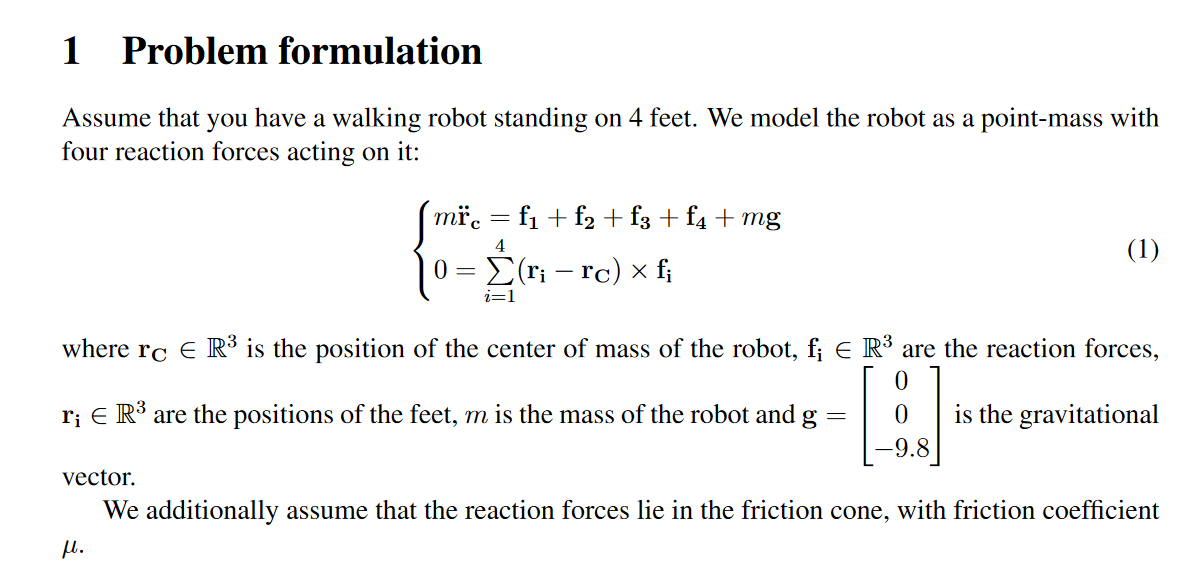

Let's take a closer look at the constraints. In statics, the sum of the moments of all forces applied to the body is equal to zero, and this leads to 2 equations. The case of friction is considered below: </br>
The reaction force $f$ is the sum of tangential and normal projections:  <br> $\bf  f = f_{t} + f_{n}$
Where normal projection is the multiplication of normal vector and dot product of the reaction force and normal vector<br> $\bf f_{n} = (f,n)n$ <br>
And tangential component is: <br> $\bf  f_{t} =  f - f_{n}$ <br>
A point contact remains in the fixed contact mode while its contact force $\bf f$ lies inside the friction cone directed by normal vector to a plane $\bf n$: <br>
$||f_{t}||_{2} <= \mu(f,n)$

In [1]:
import numpy as np
import numpy.linalg as LA
from random import uniform
import matplotlib.pyplot as plt
from scipy.linalg import null_space
import cvxpy as cp
%matplotlib inline

In [2]:
#Constants:
g = np.array([[0,0,-9.8]]) 
mu = 0.5
#robot's mass:
m = 1 
#default number of elements in arrays:
N=100 
#default array for plane construction:
def_array = np.linspace(-10,10,N) 

Geometrical functions part:

In [3]:
class plane_from_null_space:
    """Class from previous assignment. Useful for constracting plane:"""
    def __init__(self,v,w,p):
        self.v = v
        self.w = w
        self.p = p
        #Null space and basis:
        self.null_s = self.null_space()
        #Normal vector:
        self.normal = self.norm_vector()
        #Cartesian coordinates:
        self.x, self.y, self.z = self.cartesian(v,w)

    def null_space(self):
        "Obtaining null space"
        return null_space(np.vstack([self.v, self.w]))
    
    def norm_vector(self):
        "Obtaining normalized by one normal vector"
        return np.cross(self.v,self.w)/ np.linalg.norm(np.cross(self.v,self.w))

    def cartesian(self,v,w):
        "Calculation x,y,z coordinates of plane"
        A,B,C = self.null_s
        if np.abs(C)>=1e-10:
            #Usual cases:
            x,y = np.meshgrid(def_array.copy(),def_array.copy())
            z = ( A * (x - self.p[0,0]) + B * (y-self.p[0,1])) \
                * (-1) / C  + self.p[0,2]
        else:
            #Vertical cases:
            if np.dot(v[0],np.array([1,0,0]))==0 and np.dot(w[0],np.array([1,0,0]))==0:
                y,z = np.meshgrid(def_array.copy(),def_array.copy())
                x,_ = np.meshgrid(np.linspace(0,0,N),np.linspace(0,0,N)) + self.p[0,0]

            elif np.dot(v[0],np.array([0,1,0]))==0 and np.dot(w[0],np.array([0,1,0]))==0:
                x,z = np.meshgrid(def_array.copy(),def_array.copy())
                y,_ = np.meshgrid(np.linspace(0,0,N),np.linspace(0,0,N)) + self.p[0,1]
                        
        return x,y,z
    
def randomized_leg_coordinates(Plane,legs_num=4):
    """
    Task 1,2
    Function for calculation of random position of legs on a given Plane
    """
    def randomizer(plane_coordinate):
        """Function for choose random point in each coordinate (x,y,z)"""
        index = np.random.randint(N)
        if plane_coordinate[0][index]==plane_coordinate[1][index]:
            coord = plane_coordinate[0][index]
        else:
            coord = plane_coordinate[index][0]
        return index,coord
    
    legs_list = []
    for i in range(legs_num):
        x_index,x = randomizer(Plane.x)
        y_index,y = randomizer(Plane.y)
        z = Plane.z[y_index,x_index]
        legs_list.append(np.array([[x,y,z]]))
    return legs_list

def randomized_leg_coordinates_with_vertical_wall(Plane):
    """
    Tasks 3,4
    Function for calculation of random position of legs with 3 legs on a given Plane and 1 in vertical wall
    """
    #3 legs on tilted plane:
    legs_list = randomized_leg_coordinates(Plane,legs_num=3)
    
    #1 leg in vertical wall:
    legs_list.append(randomized_leg_coordinates(V_Plane,legs_num=1)[0])
    return legs_list

def scew_symm(r):
    """
    Function for cross-product calculation by scew-matrix:
    """
    a = np.zeros((3,3),dtype=np.float32)
    a[0,1],a[1,0] = -r[0,2],r[0,2]
    a[0,2],a[2,0] = r[0,1],-r[0,1]
    a[1,2],a[2,1] = -r[0,0],r[0,0]
    return a

In [4]:
class Robot_stabilization:
    """Class to find if there exist reaction forces that allow the robot to maintain static stability"""
    def __init__(self,v,w,p,legs_func):
        #Step 1: Construct plane:
        self.Plane = plane_from_null_space(v,w,p)
        #Step 2: Generate random points corresponding to each leg of robot (r_i):    
        self.legs = legs_func(self.Plane)
        #Step 3: Calculation of the position of the center of mass of the robot:
        self.r_c = np.sum(self.legs,axis=0)/4  
        #Step 4: Force-Variables Assignment
        self.forces = [cp.Variable((1,3)) for i in range(4)]
        #Step 5: Defining a constrains from Static equations:
        self.constraints = self.constraints_equations()
        #Step 6: Solve problem with given constraints:
        self.solver()
    
    def constraints_equations(self):
        global legs_list
        constraints, sum_of_moments = [], []
        for i in range(4):
            r_hat = scew_symm(self.legs[i]-self.r_c)
            sum_of_moments.append(r_hat @ self.forces[i].T)
            
        ##Sum of moments should be equal to 0:
        constraints.append(np.sum(sum_of_moments,axis=0)==np.array([[0,0,0]]))
        ##Sum of forces should be equal to 0:
        constraints.append(np.sum(self.forces,axis=0)==-m*g)  
        #Friction part f_t <= mu*f_n:
        for i in legs_list:
            # Normal component of contact force:
            dot_prod = cp.sum(self.Plane.normal @ self.forces[i].T) #Scalar form of normal compomnent
            f_n =  dot_prod * self.Plane.normal #Vectorized form
            # Tangential component of contact force:
            f_t = self.forces[i] - f_n 
            constraints.append(cp.norm2(f_t) <= mu * dot_prod)
            
        return constraints
    
    def solver(self):
        obj = cp.Minimize(0)
        prob = cp.Problem(obj, self.constraints)
        result = prob.solve()
        
        if self.forces[0] is not None:
            print("There is a solution:")
            for i in range(4):
                print("Force",i,":",self.forces[i].value)
        else:
            print("Robot is unstable")
        

#### Task1: 
##### Given $r_C$, and $r_i$ find if there exist reaction forces that allow the robot to maintain static stability (1) with $\frac{d^2r_c}{dt^2}$ = 0, given that the robot stands on horizontal ground.

In [67]:
legs_list = [0,1,2,3] # Free legs (not nailed)
#Horizontal plane case:
v = np.array([[1,0,0]])
w = np.array([[0,1,0]])
p = np.array([[0,0,0]])
Robot_instance = Robot_stabilization(v,w,p,randomized_leg_coordinates)

There is a solution:
Force 0 : [[0.         0.         2.48636611]]
Force 1 : [[0.         0.         2.35425126]]
Force 2 : [[0.         0.         2.43122874]]
Force 3 : [[0.         0.         2.52815389]]


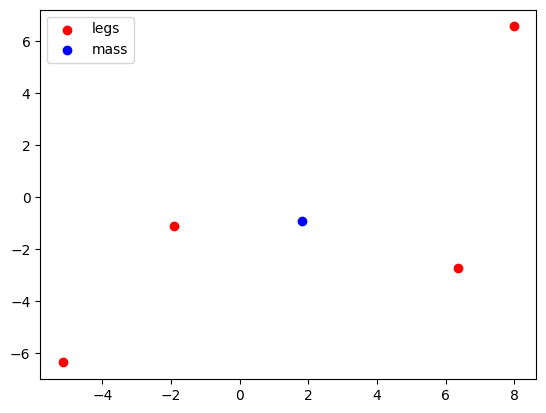

In [53]:
#Plot result:
legs_plot = [plt.scatter(Robot_instance.legs[i][0,0],Robot_instance.legs[i][0,1],color='r') for i in range(4)]
r_c_plot = plt.scatter(Robot_instance.r_c[0,0],Robot_instance.r_c[0,1],color='b')
plt.legend([legs_plot[0],r_c_plot],['legs','mass'])
plt.show()

#### Task2: 
##### Solve the previous problem, but assume that the robot stands on tilted ground.

In [7]:
#Tilted plane case:
v = np.array([[1,0,0.2]])
w = np.array([[0,1,0]])
p = np.array([[0,0,0]])
Robot_instance = Robot_stabilization(v,w,p,randomized_leg_coordinates)

There is a solution:
Force 0 : [[-0.0260372   0.01126017  2.33153763]]
Force 1 : [[-0.03687074 -0.03022867  2.47245907]]
Force 2 : [[0.02053166 0.01749063 2.61255878]]
Force 3 : [[4.23762734e-02 1.47787098e-03 2.38344451e+00]]


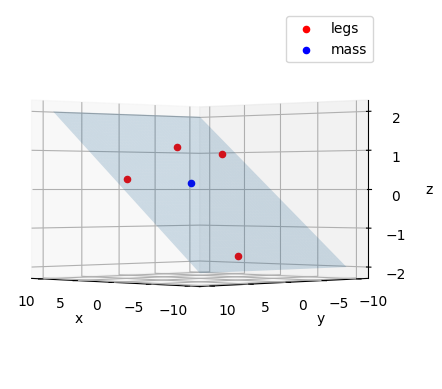

In [8]:
#Plot result:
#Setup:
ax = plt.subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0, azim=135)
x,y = np.meshgrid(def_array.copy(),def_array.copy())

#Plane:
ax.plot_surface(x, y, Robot_instance.Plane.z, alpha = 0.2)
#Legs:
legs_plot = [ax.scatter(Robot_instance.legs[i][0,0],Robot_instance.legs[i][0,1],Robot_instance.legs[i][0,2],color='r') for i in range(4)]
#Center of mass:
r_c_plot = ax.scatter(Robot_instance.r_c[0,0],Robot_instance.r_c[0,1],Robot_instance.r_c[0,2],color='b')
plt.legend([legs_plot[0],r_c_plot],['legs','mass'])

plt.show()

#### Task3: 
##### Solve the previous problem, but assume that one of the feet pushes against a vertical wall instead of standing on the ground.

In [9]:
#Construct vertical wall:
v = np.array([[0,0,1]])
w = np.array([[0,1,0]])
p = np.array([[-10,0,0]])
V_Plane = plane_from_null_space(v,w,p)

In [69]:
#Tilted plane:
v = np.array([[1,0,0.3]])
w = np.array([[0,1,0]])
p = np.array([[0,0,0]])
Robot_instance = Robot_stabilization(v,w,p,randomized_leg_coordinates_with_vertical_wall)

There is a solution:
Force 0 : [[ 0.00760651 -0.04194668  2.3752612 ]]
Force 1 : [[-0.00989081  0.0212509   2.04306121]]
Force 2 : [[ 0.02089308 -0.00823774  3.05798395]]
Force 3 : [[-0.01860878  0.02893352  2.32369364]]


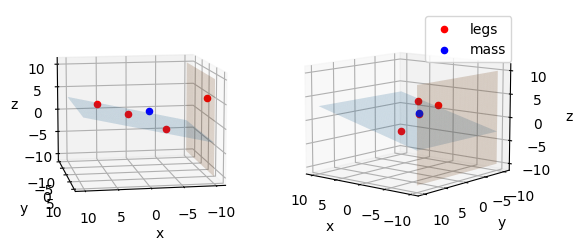

In [70]:
#Plot part:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="3d"))
for i in range(2):
#Setup:
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_zlabel('z')
    axs[i].view_init(elev=10, azim=80 + i*50)
    x,y = np.meshgrid(def_array.copy(),def_array.copy())

    #Planes:
    axs[i].plot_surface(Robot_instance.Plane.x, Robot_instance.Plane.y, Robot_instance.Plane.z, alpha = 0.2)
    axs[i].plot_surface(V_Plane.x, V_Plane.y, V_Plane.z, alpha = 0.2)

    #Legs:
    legs_plot = [axs[i].scatter(Robot_instance.legs[j][0,0],Robot_instance.legs[j][0,1],Robot_instance.legs[j][0,2],color='r') for j in range(4)]
    #Center of mass:
    r_c_plot = axs[i].scatter(Robot_instance.r_c[0,0],Robot_instance.r_c[0,1],Robot_instance.r_c[0,2],color='b')
plt.legend([legs_plot[0],r_c_plot],['legs','mass'])
plt.show()

#### Task4: 
##### Solve the previous problem, but assume that one of the feet is nailed to the floor.

In [12]:
#Assumed plane:
v = np.array([[1,0,0.3]])
w = np.array([[0,1,0]])
p = np.array([[0,0,0]])

#Leg to be nailed:
nailed_num = 2
legs_list = [0,1,2,3] # Free legs (not nailed)

#Function to obtain random coordinates once, and then pass them in two cases: free legs, and one nailed
compare_friction_cases = randomized_leg_coordinates_with_vertical_wall(plane_from_null_space(v,w,p))
randomized_leg_coordinates_with_vertical_wall_for_compare_cases = lambda a: compare_friction_cases

#Calculation part:
print("All legs are free:")
for i in range(2):
    Robot_instance = Robot_stabilization(v,w,p,randomized_leg_coordinates_with_vertical_wall_for_compare_cases)
    if i ==0:
        #Nail the leg:
        legs_list.remove(nailed_num)
        print("\nLeg number %d is nailed: " % nailed_num)  

All legs are free:
There is a solution:
Force 0 : [[0.04877494 0.01925796 3.24066618]]
Force 1 : [[-0.08062355 -0.01417202  2.07835563]]
Force 2 : [[0.01167176 0.04151254 2.51199357]]
Force 3 : [[ 0.02017686 -0.04659848  1.96898462]]

Leg number 2 is nailed: 
There is a solution:
Force 0 : [[-0.76789645 -0.09001053  2.60969728]]
Force 1 : [[-0.64530483 -0.10768637  2.19214356]]
Force 2 : [[2.14363602 0.3815336  2.5243786 ]]
Force 3 : [[-0.73043474 -0.1838367   2.47378056]]


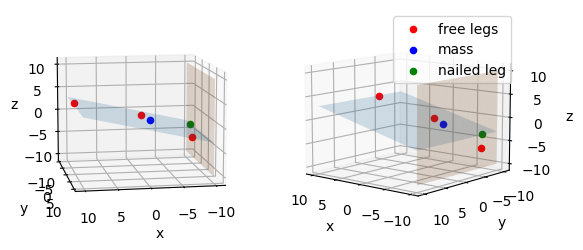

In [13]:
#Plot part:
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="3d"))
for i in range(2):
#Setup:
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_zlabel('z')
    axs[i].view_init(elev=10, azim=80 + i*50)
    x,y = np.meshgrid(def_array.copy(),def_array.copy())

    #Planes:
    axs[i].plot_surface(Robot_instance.Plane.x, Robot_instance.Plane.y, Robot_instance.Plane.z, alpha = 0.2)
    axs[i].plot_surface(V_Plane.x, V_Plane.y, V_Plane.z, alpha = 0.2)

    #Legs:
    legs_plot = [axs[i].scatter(Robot_instance.legs[j][0,0],Robot_instance.legs[j][0,1],Robot_instance.legs[j][0,2],color='r') for j in legs_list]
    #Nailed leg:
    nailed_leg_plot = axs[i].scatter(Robot_instance.legs[nailed_num][0,0],Robot_instance.legs[nailed_num][0,1],Robot_instance.legs[nailed_num][0,2],color='g')
    #Center of mass:
    r_c_plot = axs[i].scatter(Robot_instance.r_c[0,0],Robot_instance.r_c[0,1],Robot_instance.r_c[0,2],color='b')
plt.legend([legs_plot[0],r_c_plot,nailed_leg_plot],['free legs','mass','nailed leg'])
plt.show()